# Risk assessment — affected population

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

Combine projections of wildfire hazard with projections of population and count the population affected by a specific level of hazard in the future.

## Preparation work

### Load libraries

:::{admonition} Information about the libraries used in this workflow
:class: hint dropdown

- [os](https://docs.python.org/3/library/os.html) - Operating system interaction and file path manipulation.
- [pathlib](https://docs.python.org/3/library/pathlib.html) - Convenient file path manipulation.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - Zip archive handling.
- [numpy](https://numpy.org/) - A powerful library for numerical computations, widely used for array operations and mathematical functions.
- [geopandas](https://geopandas.org/en/stable/index.html) - Geometric operations for geospatial data in [pandas](https://pandas.pydata.org/).
- [xarray](https://docs.xarray.dev/en/stable/) - Library for working with labelled multi-dimensional arrays.
- [rioxarray](https://corteva.github.io/rioxarray/html/index.html) - Geospatial operations for xarray based on GDAL/rasterio.
- [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) - Visualisation tools and templates designed for earth science data.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - Data download utility with DOI support.
:::

In [1]:
import os
import pathlib
import zipfile

import earthkit.plots as ekp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pooch
import xarray as xr

### Set location

Used for labelling and to locate data from previous steps of the workflow.

In [2]:
location = "Andalucía"

### Path configuration

In [3]:
data_dir = pathlib.Path("./data")

# Shapefile of region that is analysed
region_path = data_dir / location / "region"

# Folder for population data
pop_dir = data_dir / "population"

### Load region geometry

In [4]:
region = gpd.read_file(region_path)

## Step 1: Import population projections

[Wang et al. (2022)](https://doi.org/10.6084/m9.figshare.19608594.v3) have modelled the global population distribution from 2020 to 2100 in 5-year steps under five shared socioeconomic pathway (SSP) scenarios:

- `SSP1`: "Taking the Green Road"
- `SSP2`: "Middle of the Road"
- `SSP3`: "A Rocky Road"
- `SSP4`: "A Road Divided"
- `SSP5`: "Taking the Highway"

### Select a scenario

In [5]:
ssp = "SSP1"

### Download data

Projections are available in GeoTIFF format packaged into a zip archive per SSP.

:::{tip}

You can skip this substep if you already downloaded the data.
:::

In [ ]:
population_pooch = pooch.create(
    base_url="doi:10.6084/m9.figshare.19608594.v3",
    path=pop_dir,
    registry={
        "SPP1.zip": "3ec4587810b7ca5201d2a19bf37fc447a88559b3841aadbf675d9c3a738c285e",
        "SSP2.zip": "00d7f9e79504c1936ba86b0857c7e7ac4015f9a05a3e13d328f9487bec6eddd7",
        "SSP3.zip": "f8de3ef275d3fb40b11a0d65259639f40286f95a42d57d60fde5a7967a2d91d1",
        "SSP4.zip": "e307e0eff29c1ae91d99bd9a8ae4498b122b01e59329d75e544d11641db8defb",
        "SSP5.zip": "2af4b5f9886db0153d4dbd0ba229078baeeab3fe355906d40eb034835cad5190",
    }
)

In [ ]:
# Exception for a typo in the scenario names in the data repository
population_filename = "SPP1.zip" if ssp == "SSP1" else f"{ssp}.zip"

# Download from repository
population_filename = population_pooch.fetch(population_filename, progressbar=True)

Unpack all GeoTIFF files from the downloaded archive into the population data folder:

In [ ]:
with zipfile.ZipFile(pop_archive) as zobj:
    # Extract without keeping structure (https://stackoverflow.com/a/47632134)
    for zinfo in zobj.infolist():
        if not zinfo.filename.endswith(".tif"):
            continue
        zinfo.filename = os.path.basename(zinfo.filename)
        zobj.extract(zinfo, path=pop_dir)

Remove the archive to reduce disk usage:

In [ ]:
os.remove(pop_archive)

### Import and clip data

Load the population projections for all years:

In [6]:
def assign_year(ds):
    """Assign a year coordinate based on value extracted from the filename"""
    year = int(ds.encoding["source"][-8:-4])
    return ds.squeeze().assign_coords({"year": year})

population = xr.open_mfdataset(
    sorted(pop_dir.glob(f"{ssp}_*.tif")),
    engine="rasterio",
    preprocess=assign_year,
    concat_dim="year",
    combine="nested",
    chunks="auto"
)

Preselect and set metadata for convenience:

In [7]:
population = population["band_data"].rename("population").squeeze()

Only keep population data for the region of interest:

In [8]:
# Data is on a lat-lon grid. Preselect with the bounding box of
# the region shapefile to speed up clipping with rasterio 
bbox = region.total_bounds
population = population.sel({
    "x": slice(bbox[0], bbox[2]),
    "y": slice(bbox[3], bbox[1])
}).compute()

# Now clip to the actual region boundaries
population = population.rio.clip(region.geometry, all_touched=True)

### Evolution of the total population

Sum across the region to get the total population:

In [9]:
total_population = population.sum(dim=["x", "y"])

For a first look at the population data, visualize the projected evolution of the total population and a population map for one year as an example:

/opt/conda/lib/python3.11/site-packages/earthkit/plots/metadata/labels.py:121: UserWarning: No key "units" found in layer metadata.
  warnings.warn(f'No key "{attr}" found in layer metadata.')


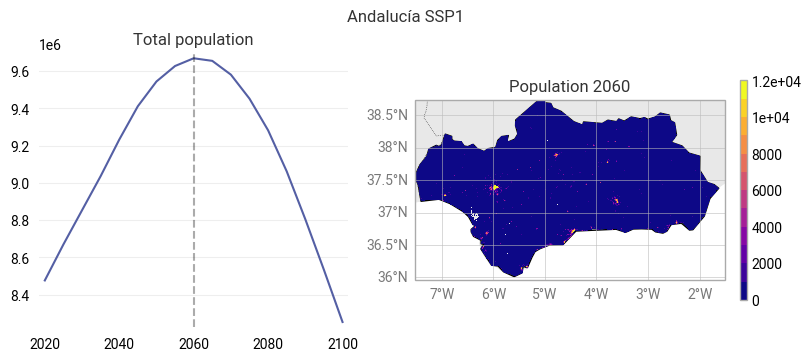

In [10]:
fig = ekp.Figure(rows=1, columns=2, size=(8, 3.5))
fig.title(f"{location} {ssp}")

# Determine the year at which the population is largest (or choose a year of interest)
year = int(total_population.idxmax().values)

# Temporal evolution of the total population
subplot = fig.add_subplot()
subplot.title("Total population")
subplot.line(x=population["year"].values, y=total_population.values)
subplot.ax.axvline(year, color="black", alpha=0.33, linestyle="dashed")

# Population map for the year of interest
subplot = fig.add_map()
subplot.title(f"Population {year}")
region.plot(ax=subplot.ax, edgecolor="black", facecolor="none")  # Outline of selected region
subplot.block(population.sel({"year": year}))
subplot.legend(location="right")
subplot.land()
subplot.borders()
subplot.gridlines()

:::{note}

The values in the population map indicate the number of inhabitants per grid cell.
:::

## Step 2: Import hazard projections

Import the hazard projections constructed in the final notebook of the hazard assessment.
Specify the name of a response model as assigned during its export and the RCP scenario of the climate projections it has been evaluated with:

In [11]:
# Response model
hazard_name = "hazard_pe_60.0"

# Climate scenario
rcp = "RCP4.5"

hazard_dir = data_dir / location / hazard_name

Load the corresponding hazard indicator data:

In [12]:
hazard = xr.open_dataarray(hazard_dir / f"response_{rcp}.nc", decode_coords="all")
hazard

<xarray.DataArray 'response' (decade: 10, run: 9, y: 12, x: 24)> Size: 207kB
[25920 values with dtype=float64]
Coordinates:
  * y            (y) float64 96B 36.0 36.25 36.5 36.75 ... 38.0 38.25 38.5 38.75
  * x            (x) float64 192B -7.5 -7.25 -7.0 -6.75 ... -2.25 -2.0 -1.75
  * run          (run) <U28 1kB 'ec_earth-hirham5-r3i1p1' ... 'noresm1_m-hirh...
  * decade       (decade) int64 80B 2000 2010 2020 2030 ... 2060 2070 2080 2090
    spatial_ref  int64 8B ...
Attributes:
    location:   Andalucía
    threshold:  60.0
    variable:   pe
    label:      probability of exceeding FWI 60.0 in a year
    units:      %
    rcp:        RCP4.5

:::{tip}

While this population-based risk assessment is preconfigured for a wildfire hazard indicator, it can easily be adapted for indicators of other hazards.
:::

## Step 3: Count the affected population

Combine the projections of wildfire hazard and population to determine the future risk of wildfire conditions for the inhabitants of the region of interest.

In [13]:
def sum_where_level_exceeded(data, data_where, level):
    counts = data.where(data_where >= level).sum(dim=["y", "x"])
    return counts.assign_coords({"level": level})


def affected_population(hazard, population, levels, decade):
    # Hazard data is given in 10 year steps with each data point representative of a decade,
    # e.g., decade 2030 represents years 2030-2039 (inclusive). The population data is given
    # in 5 year steps with each value representing the year for which it is valid. To align,
    # select the middle year of each decade to represent the population of that decade. E.g.,
    # for decade 2030-2039, take the population projection for 2035.
    population = population.sel({"year": decade + 5})
    
    # Resample to the grid of the highest-resolution dataset. This usually means resampling
    # the hazard data to match the population data.
    hazard = hazard.sel({"decade": decade}).rio.reproject_match(population)
    
    # Sum the population for each level (could also be implemented with numpy's digitize,
    # bincount and cumsum, but not all have xarray equivalents)
    counts = xr.concat(
        [sum_where_level_exceeded(population, hazard, level) for level in levels],
        dim="level"
    )
    return counts.assign_coords({"decade": decade}).rename("affected_population")

Split the value range of the hazard indicator into a set of thresholds and count the population where the the hazard indicator exceeds each threshold.

In [14]:
# Decades to evaluate
decades = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

# Levels for the hazard exceedance (adapt to the selected hazard indicator)
# Default: probability of exceedance from 0% to 100% in steps of 1%
hazard_levels = np.linspace(0, 100, 101)

# Count for all decades and model runs
counts = xr.concat(
    [affected_population(hazard, population, hazard_levels, decade) for decade in decades],
    dim="decade"
)

:::{tip}

Adapt the hazard levels to the imported hazard indicator.
:::

## Step 4: Risk analysis

### Affected population for all hazard levels

For a specific decade, show the number of inhabitants in areas where a hazard level is exceeded plotted against all sampled hazard levels.
An uncertainty estimate based on the ensemble of hazard projections can be made.

Text(0, 0.5, 'affected population (#)')

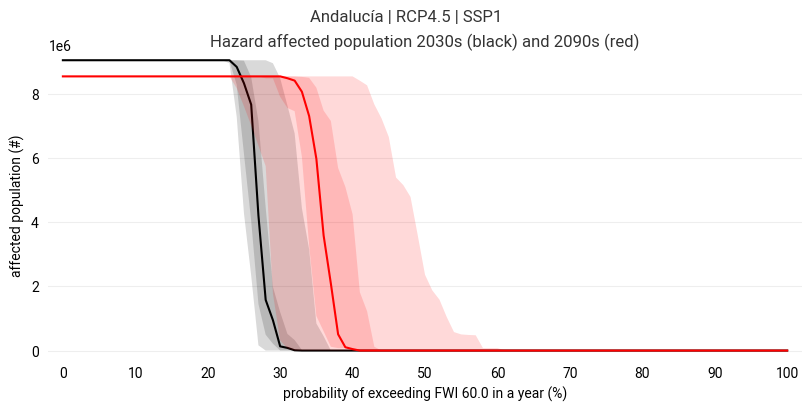

In [15]:
# Choose two decades to compare
decade_1 = 2030
decade_2 = 2090

figure = ekp.Figure(size=(8, 4))
figure.title(f"{location} | {rcp} | {ssp}")

subplot = figure.add_subplot()
subplot.title(f"Hazard affected population {decade_1}s (black) and {decade_2}s (red)")
subplot.quantiles(
    counts.sel({"decade": decade_1}),
    x=counts["level"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0],
    color="black"
)
subplot.quantiles(
    counts.sel({"decade": decade_2}),
    x=counts["level"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0],
    color="red"
)
subplot.ax.set_xticks(np.linspace(0, 100, 11))
subplot.ax.set_xlabel("{label} ({units})".format(**hazard.attrs))
subplot.ax.set_ylabel("affected population (#)")

Each point along the graph indicates how many people (read from y-axis) inhabit the areas where a hazard level (read from x-axis) is exceeded.
The line shows the median projection, while the shaded regions indicate the 25-75 percentile (dark) and total (light) range of all projections.

- As the affected area generally becomes smaller with increasing threshold (going left to right in the plot), the affected population also decreases.
- The affected population decreases sharply when a densely populated area drops out of the affected area as the hazard level decreases.
- If there is a **minimum threshold** that the entire population is affected by, the line will start at the total population count on the left and stay there until this threshold value is reached, after which the affected population count decreases.
- If there is a **maximum threshold** that no part of the population is affected by, the line will go to 0 and stay there after this threshold value has been reached.

### Evolution of the affected population for a specific hazard level

For a specific hazard level, determine the affected population over time.

Text(0, 0.5, 'affected population (#)')

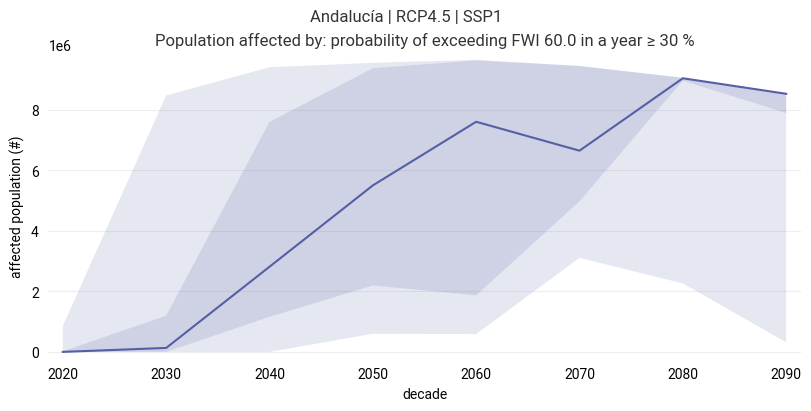

In [16]:
# Choose a hazard level to evaluate. Has units of the hazard indicator,
# e.g., % for a probability of exceedance.
level = 30

figure = ekp.Figure(size=(8, 4))
figure.title(f"{location} | {rcp} | {ssp}")

subplot = figure.add_subplot()
subplot.title(f"Population affected by: {hazard.attrs['label']} ≥ {level} {hazard.attrs['units']}")
subplot.quantiles(
    counts.sel({"level": level}),
    x=counts["decade"],
    dim="run",
    quantiles=[0.0, 0.25, 0.5, 0.75, 1.0]
)
subplot.ax.set_xlabel("decade")
subplot.ax.set_ylabel("affected population (#)")

The plot shows the median count of the affected population (line) and the uncertainty in form of the 25-75 percentile (dark shading) and total (light shading) range of all projections.


:::{note}

The uncertainty range only considers the uncertainty associated with the hazard indicator.
Information on the uncertainty of the population projections is not available for the preconfigured dataset.
:::

## Step 5: Export data

Write the affected population counts for all sampled hazard levels:

In [17]:
counts.attrs = {
    "location": location,
    "RCP": rcp,
    "SSP": ssp,
    "hazard": hazard.attrs["label"]
}
counts.to_netcdf(hazard_dir / f"affected_population_{ssp}_{rcp}.nc")

## Summary

By combining projections of wildfire hazard and population, we have estimated the population-at-risk for wildfire hazard until the end of the century for a region of interest.
An uncertainty range for the population counts was determined from the ensemble of hazard projections.